In [44]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
from random import sample
import datetime

In [45]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [26]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
%config IPCompleter.greedy=True

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [27]:
fashion_mnist = keras.datasets.fashion_mnist

In [28]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

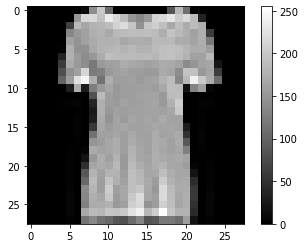

In [7]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

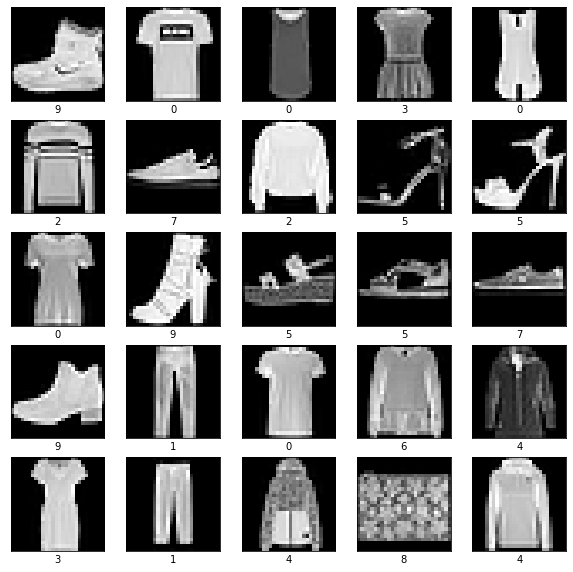

In [9]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

# Feature Engineering 
### One-hot-encoding
Se debe crear un diccionario que relaciones los nombres de las clases con su respectivo valor numérico en los datasets

In [29]:
classes_dict = {0: 'T-shirt/top', 
                1: 'Trouser', 
                2: 'Pullover', 
                3: 'Dress', 
                4: 'Coat', 
                5: 'Sandal', 
                6: 'Shirt', 
                7: 'Sneaker', 
                8: 'Bag', 
                9: 'Ankle boot'}
print(classes_dict)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [30]:
encoder = skp.OneHotEncoder(categories = "auto")

#Training data
encoder.fit(train_labels.reshape(-1, 1))
onehotlabels_train = encoder.transform(train_labels.reshape(-1, 1)).toarray()
print("Training:", onehotlabels_train.shape)

#Testing data
encoder.fit(test_labels.reshape(-1, 1))
onehotlabels_test = encoder.transform(test_labels.reshape(-1, 1)).toarray()
print("Testing:", onehotlabels_test.shape)

Training: (60000, 10)
Testing: (10000, 10)


### Procesamiento de imagenes
Las imagenes (matrices) deben ser convertidas a vectores para facilitar la creación de modelos con los $\theta$ en un solo vector de pesos.

Crear 3 datasets de entrenamiento: 
* Datos crudos
* Normalizado
* Escalado

Ya que la data será entrenada con 3 _tipos_ de entradas, es necesario recordar que la data de prueba también deberá pasar por el mismo preprocesamiento. Así que aprovechamos a crear funciones para realizar estas transformaciones.

In [31]:
#images: set de imagenes de keras, cada imagen es de 28x28 pixeles
#mode: 1 para crudos, 2 para normalizados y 3 para escalados
def image_transformation(images, mode = 1):
    salida = images.reshape(-1, 28 * 28)
    
    if(mode == 2): #Normalizar
        salida = skp.normalize(salida, norm = "max", axis = 1)
    elif(mode == 3):#Escalar
        salida = skp.scale(salida)
    #Agregar sesgo
    salida = np.insert(salida, 0, np.ones(len(salida)), axis=1).astype(np.float32)
    
    return salida

In [32]:
#Data cruda
x_train = image_transformation(train_images)
x_test = image_transformation(test_images)

print(x_train.shape)

(60000, 785)


In [33]:
#Data normalizada
x_train_normalized = image_transformation(train_images, 2)
x_test_normalized = image_transformation(test_images, 2)

In [34]:
#Data escalada
x_train_scaled = image_transformation(train_images, 3)
x_test_scaled = image_transformation(test_images, 3)

# Regresión Logística
## Definición de clases y métodos
Se crea una clase con las funciones adecuadas para realizar regresión logística con Softmax.

In [35]:
class LRSoftmax:
    def __init__(self, x, labels):
        self.theta = tf.get_variable(shape = [x.shape[1], labels.shape[1]], 
                                 dtype = tf.float32, 
                                 initializer = tf.zeros_initializer(),
                                 name = "theta")
    
    def logits(self, x):
        return tf.matmul(x, self.theta)
    
    def prediction(self, x):
        return tf.nn.softmax(self.logits(x))
    
    def accuracy(self, predictions, labels):
        _, accuracy = tf.metrics.accuracy(labels = tf.argmax(labels, 1),
                                          predictions = tf.argmax(predictions, 1))
        return accuracy
    
    def update(self, x_train, labels_train, x_test, labels_test, learning_rate):
        with tf.name_scope("cross_entropy"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_train, 
                                                                                 logits = self.logits(x_train)))
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_test, 
                                                                                logits = self.logits(x_test)))
            train_error_summary = tf.summary.scalar("train_error", train_error)
            test_error_summary = tf.summary.scalar("test_error", test_error)
        with tf.name_scope("accuracy"):
            train_accuracy = self.accuracy(self.prediction(x_train), labels_train)
            test_accuracy = self.accuracy(self.prediction(x_test), labels_test)
            train_accuracy_summary = tf.summary.scalar("train_accuracy", train_accuracy)
            test_accuracy_summary = tf.summary.scalar("test_accuracy", test_accuracy)
        
        with tf.name_scope("update"):
            gradient = tf.gradients(train_error, [self.theta])
            theta_new = tf.assign(self.theta, self.theta - learning_rate * gradient[0])
            
        return theta_new, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [36]:
def training(learning_rate, epochs, imprimir_error_cada, x_train, x_test, labels_train, labels_test, batch_size = 32):
    log = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" +str(learning_rate) + "_epochs=" + str(epochs)
    g = tf.Graph()
    
    with g.as_default():
        modelo = LRSoftmax(x_train, labels_train)
        
        with tf.name_scope("train_tensor"):
            tensor_x_train = tf.placeholder(tf.float32, [None, x_train.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None, labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("test_tensor"):
            tensor_x_test = tf.placeholder(tf.float32, [x_test.shape[0], x_test.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        
        update_parameters = modelo.update(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, learning_rate)
        writer = tf.summary.FileWriter(log, g)
        
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = x_train[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                parameters_dict = {tensor_x_train: batch_data, 
                             tensor_labels_train: batch_labels,
                             tensor_x_test: x_test,
                             tensor_labels_test: labels_test}
                training = session.run(update_parameters, feed_dict = parameters_dict)
                
                if (i % imprimir_error_cada == 0):
                    theta = session.run(modelo.theta, feed_dict = parameters_dict)
                    
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
            
            return theta

            writer.close()

## Grafo resultante

<img src="graph.png">

## Experimentos
Realización de experimentos para comparar resultados con los distintos tipos de entradas: crudos, normalizados y escalados.

In [39]:
theta = training(0.1, 5, 200, x_train, x_test, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<img src="images/accuracy_raw1.png">

<img src="images/error_raw1.png">

In [38]:
theta_normalized = training(0.1, 5, 200, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<img src="images/accuracy_normalized1.png">

<img src="images/error_normalized1.png">

In [37]:
theta_scaled = training(0.1, 5, 200, x_train_scaled, x_test_scaled, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<img src="images/accuracy_scaled1.png">

<img src="images/error_scaled1.png">

In [23]:
theta_normalized = training(0.01, 10, 200, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Al realizar experimentos con la data transformada, nos damos cuenta que se obtiene mucho menos error de entrenamiento al normalizar la data.

<img src="images/comparison.png">

Por lo que se procederá a hacer nuevos experimentos sólo con esta data.


In [40]:
theta_normalized = training(0.01, 15, 200, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Utilización del modelo
En _theta_normalized_ tenemos los pesos que nos ayudarán a realizar clasificación. Para ello, tomamos 10 ejemplos y los hacemos pasar por una función que determine qué son.

In [51]:
def prediction(tensor_x, img_index, theta):
    tf.reset_default_graph()
    tensor_x = tensor_x[img_index]
    tensor_x = tensor_x.reshape(1, 28*28+1)
    prediction = tf.get_variable("prediction", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tensor_x_test = tf.placeholder(tf.float32, [tensor_x.shape[0], tensor_x.shape[1]], "tensor_x_test")
    tensor_theta_test = tf.placeholder(tf.float32, [theta.shape[0], theta.shape[1]], "tensor_theta_test")
    prediction_softmax = tf.argmax(tf.nn.softmax(tf.matmul(tensor_x_test, tensor_theta_test)),1)
    
    with tf.train.MonitoredSession() as session:                     
        param_dict = {tensor_x_test: tensor_x, tensor_theta_test: theta}
        predicted_label = session.run(prediction_softmax, feed_dict = param_dict)
        classes_dict.get(int(predicted_label))
        plt.imshow(test_images[img_index], cmap = 'gray')
        plt.title(classes_dict.get(int(predicted_label)))
        plt.yticks([])
        plt.xticks([])
        plt.show()

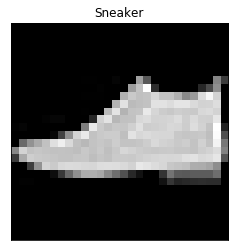

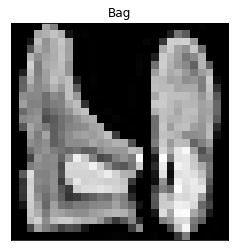

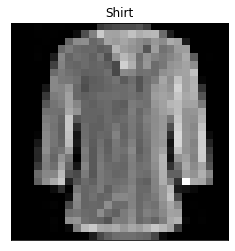

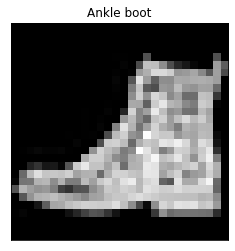

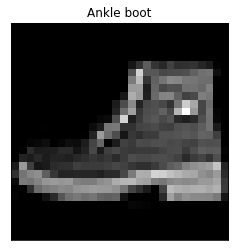

In [52]:
testing_images = list(np.linspace(0, len(x_test), len(x_test), dtype = np.int32))

for i in sample(testing_images, 5):
    prediction(x_test_normalized, i, theta_normalized)

# Conclusión
Se obseva que se obtiene un menor error de entrenamiento con la data normalizada.

El modelo obtenido clasificó 3 de las 5 pruebas correctamente. Se puede proceder a hacer más pruebas para validar la precisión con mayor certeza.



In [17]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13672), started 0:34:05 ago. (Use '!kill 13672' to kill it.)

"kill" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
